In [31]:
import numpy as np
import matplotlib.pyplot as plt 

%matplotlib inline

In [13]:
from keras.models import Sequential
from keras.layers import Dense
from keras.utils.np_utils import to_categorical


In [24]:
from keras.datasets import reuters
(train_data, train_labels), (test_data, test_labels) = reuters.load_data(nb_words=10000)

In [25]:
len(train_data)

8982

In [26]:
len(test_data)

2246

In [27]:
train_data[10]

[1,
 245,
 273,
 207,
 156,
 53,
 74,
 160,
 26,
 14,
 46,
 296,
 26,
 39,
 74,
 2979,
 3554,
 14,
 46,
 4689,
 4329,
 86,
 61,
 3499,
 4795,
 14,
 61,
 451,
 4329,
 17,
 12]

In [28]:
word_index = reuters.get_word_index()
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])
# note that our indices were offset by 3
# because 0, 1 and 2 are reserved indices for "padding", "start of sequence", and "unknown".
decoded_newswire = ' '.join([reverse_word_index.get(i - 3, '?') for i in train_data[0]])

In [29]:
train_labels[10]

3

In [30]:
def vectorize_sequences(sequences, dimension=10000):
    results = np.zeros((len(sequences), dimension))
    for i, sequence in enumerate(sequences):
        results[i, sequence] = 1.
    return results

In [31]:
# our vectorized training data
x_train = vectorize_sequences(train_data)
# our vectorized test data
x_test = vectorize_sequences(test_data)

In [32]:
one_hot_train_labels = to_categorical(train_labels)
one_hot_test_labels = to_categorical(test_labels)

In [33]:
model = Sequential()
model.add(Dense(64, activation='relu', input_dim=10000))
model.add(Dense(64, activation='relu'))
model.add(Dense(46, activation='softmax'))

In [34]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy',
              metrics=['accuracy'])

In [35]:
x_val = x_train[:1000]
partial_x_train = x_train[1000:]
y_val = one_hot_train_labels[:1000]
partial_y_train = one_hot_train_labels[1000:]

In [36]:
history = model.fit(partial_x_train, partial_y_train, nb_epoch=20, batch_size=512,
                    validation_data=(x_val, y_val))

Train on 7982 samples, validate on 1000 samples
Epoch 1/20
7982/7982 [==============================] - 6s - loss: 2.6524 - acc: 0.4726 - val_loss: 1.7200 - val_acc: 0.6380
Epoch 2/20
7982/7982 [==============================] - 1s - loss: 1.4291 - acc: 0.7030 - val_loss: 1.2767 - val_acc: 0.7120
Epoch 3/20
7982/7982 [==============================] - 1s - loss: 1.0557 - acc: 0.7751 - val_loss: 1.1047 - val_acc: 0.7690
Epoch 4/20
7982/7982 [==============================] - 1s - loss: 0.8364 - acc: 0.8206 - val_loss: 1.0090 - val_acc: 0.7700
Epoch 5/20
7982/7982 [==============================] - 1s - loss: 0.6695 - acc: 0.8554 - val_loss: 0.9435 - val_acc: 0.8050
Epoch 6/20
7982/7982 [==============================] - 1s - loss: 0.5347 - acc: 0.8896 - val_loss: 0.9179 - val_acc: 0.8040
Epoch 7/20
7982/7982 [==============================] - 1s - loss: 0.4342 - acc: 0.9105 - val_loss: 0.8839 - val_acc: 0.8200
Epoch 8/20
7982/7982 [==============================] - 1s - loss: 0.3512 - a

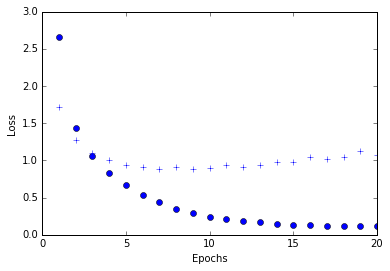

In [37]:
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, loss_values, 'bo')
plt.plot(epochs, val_loss_values, 'b+')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

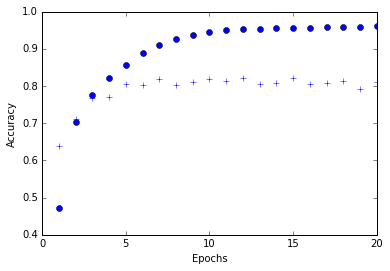

In [38]:
acc_values = history_dict['acc']
val_acc_values = history_dict['val_acc']
plt.plot(epochs, acc_values, 'bo')
plt.plot(epochs, val_acc_values, 'b+')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

In [39]:
model = Sequential()
model.add(Dense(64, activation='relu', input_dim=10000))
model.add(Dense(64, activation='relu'))
model.add(Dense(46, activation='softmax'))
model.compile(optimizer='rmsprop', loss='categorical_crossentropy',
              metrics=['accuracy'])
model.fit(x_train, one_hot_train_labels, nb_epoch=9, batch_size=512,
          validation_data=(x_test, one_hot_test_labels))
results = model.evaluate(x_test, one_hot_test_labels)

Train on 8982 samples, validate on 2246 samples
Epoch 1/9
8982/8982 [==============================] - 9s - loss: 2.4272 - acc: 0.5480 - val_loss: 1.6240 - val_acc: 0.6679
Epoch 2/9
8982/8982 [==============================] - 2s - loss: 1.3094 - acc: 0.7238 - val_loss: 1.3303 - val_acc: 0.7070
Epoch 3/9
8982/8982 [==============================] - 2s - loss: 0.9920 - acc: 0.7826 - val_loss: 1.1538 - val_acc: 0.7556
Epoch 4/9
8982/8982 [==============================] - 2s - loss: 0.7807 - acc: 0.8371 - val_loss: 1.0508 - val_acc: 0.7711
Epoch 5/9
8982/8982 [==============================] - 2s - loss: 0.6176 - acc: 0.8703 - val_loss: 0.9922 - val_acc: 0.7747
Epoch 6/9
8982/8982 [==============================] - 2s - loss: 0.4915 - acc: 0.8985 - val_loss: 0.9579 - val_acc: 0.7907
Epoch 7/9
8982/8982 [==============================] - 2s - loss: 0.3926 - acc: 0.9162 - val_loss: 0.9592 - val_acc: 0.7867
Epoch 8/9
8982/8982 [==============================] - 2s - loss: 0.3222 - acc: 0.93

In [40]:
results

[0.95542759440991887, 0.79118432769367764]

In [41]:
import copy

test_labels_copy = copy.copy(test_labels)
np.random.shuffle(test_labels_copy)
float(np.sum(np.array(test_labels) == np.array(test_labels_copy))) / len(test_labels)

0.19723953695458593

In [43]:
predictions = model.predict(x_test)

In [44]:
predictions[0].shape

(46,)

In [46]:
np.sum(predictions[0])

0.99999988

In [47]:
np.argmax(predictions[0])

3

In [48]:
predictions[0]

array([  7.23311177e-06,   1.30492917e-04,   1.90090832e-05,
         9.57346201e-01,   3.64323743e-02,   4.25556755e-06,
         1.23564296e-05,   5.84310192e-06,   1.45786756e-03,
         2.75810453e-06,   5.33384300e-05,   1.46941034e-04,
         3.19128303e-05,   3.86889842e-05,   1.86112782e-04,
         3.24078101e-05,   1.41638727e-03,   1.33268972e-04,
         3.90569403e-06,   9.76165640e-04,   1.89765065e-04,
         2.54586746e-04,   1.39069180e-05,   2.41868765e-05,
         4.98469399e-06,   1.86865786e-04,   1.63079505e-07,
         8.43011458e-06,   3.04349851e-06,   4.54893998e-05,
         3.65626365e-05,   7.28990126e-05,   5.96369046e-06,
         2.48961874e-06,   1.62048324e-04,   1.15946923e-05,
         7.18201627e-05,   4.61796699e-05,   8.71376324e-06,
         3.84192041e-04,   8.60423654e-07,   1.62173019e-05,
         2.72695729e-06,   7.28275040e-07,   3.09386735e-07,
         7.69241433e-06], dtype=float32)